# Introduction

I build a simple [xG](https://en.wikipedia.org/wiki/Expected_goals) model, try to improve it by considering some new features and then evaluate the information that can be derived from the new features.

The most important feature in determining the likelihood that a shot will result in a goal is the location from which the shot was taken, while other important factors  are the bodypart used (left foot/right foot/head), the nature of the pass that led to the shot and whether the chance arose  in open play or from a set piece. Another feature known to be of high value is whether the chance came from a fast break when defenders are likely to be out of position.

The [dataset](https://www.kaggle.com/secareanualin/football-events) I'm using contains all of these features and it is simple to build a reasonable model from these features using a gradient boosted decision tree or a neural network. 

I then try to improve my model by including some more behavioural features, and measure the value added.

In [175]:
#Import libraries
import numpy as np
import pandas as pd
import sqlite3
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import poisson
from tqdm import tqdm_notebook as tqdm
from matplotlib import colors as mcolors
from pylab import cm
import matplotlib
from scipy.stats import kurtosis
#from google.colab import drive
import os
from datetime import datetime
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
import IPython
!pip install -q -U keras-tuner
import kerastuner as kt
from kerastuner.tuners import Hyperband


# Quick analysis of the data.

In [ ]:
# this database contains player attributes
# i am interested in the players stronger foot
with sqlite3.connect('/content/data/database.db') as con:
    player_query = "SELECT * from Player"
    player = pd.read_sql_query(player_query, con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)



In [ ]:
events = pd.read_csv(events_path)
games_path = '/content/data/ginf.csv'
games = pd.read_csv(games_path)
dictionary_path = '/content/data/dictionary.txt'
dictionary = pd.read_csv(dictionary_path, header = None)

def strip_dict(dictionary,reset_keys=True):
  new_dictionary = {}
  for i,k in enumerate(dictionary.keys()):#
    if reset_keys:
      new_dictionary[i+1] = dictionary[k].split('\t')[1]  
    else:
      new_dictionary[k] = dictionary[k].split('\t')[1]  

  return new_dictionary

event_type = strip_dict(dictionary.loc[1:12,:].to_dict()[0],reset_keys=False)
event_type2 = strip_dict(dictionary.loc[14:17,:].to_dict()[0])
home_away = strip_dict(dictionary.loc[19:20,:].to_dict()[0])
shot_place = strip_dict(dictionary.loc[22:34,:].to_dict()[0])
shot_outcome = strip_dict(dictionary.loc[36:39,:].to_dict()[0])
location = strip_dict(dictionary.loc[41:59,:].to_dict()[0])
bodypart = strip_dict(dictionary.loc[61:63,:].to_dict()[0])
assist_method = strip_dict(dictionary.loc[65:69,:].to_dict()[0]);
situation = strip_dict(dictionary.loc[71:74,:].to_dict()[0])
games.date = [datetime.strptime(g[1].date,'%Y-%m-%d') for g in games.iterrows()]

assist_method_new = {}
for k in assist_method.keys():
  assist_method_new[k-1] = assist_method[k]
assist_method = assist_method_new # this counts from zero...
event_type_new = {}
for k in event_type.keys():
  event_type_new[k-1] = event_type[k]
event_type = event_type_new # this counts from zero...

In [ ]:
# add date to the events dataframe
events = pd.merge(events,games.loc[:,['id_odsp','date']],on='id_odsp',how='left')
# the games table contains references to more games than the events table
# so the events data is incomplete
events_per_game = events.groupby(['id_odsp']).id_event.count()
events_per_game.name = 'events_per_game'
games = pd.merge(games,events_per_game,on='id_odsp',how='left')
print('Games by country/season')
print(games.groupby(['country','season']).events_per_game.count().unstack())
print('Events by country/season')
print(games.groupby(['country','season']).events_per_game.sum().unstack())



Games by country/season
season   2012  2013  2014  2015  2016  2017
country                                    
england     0     0   320   380   379   220
france    368   373   378   380   369   208
germany   294   305   269   290   297   153
italy     362   379   379   379   370   207
spain     355   379   380   342   370   189
Events by country/season
season      2012     2013     2014     2015     2016     2017
country                                                      
england      0.0      0.0  29089.0  34906.0  34192.0  20733.0
france   39542.0  38075.0  37372.0  37348.0  36037.0  20072.0
germany  32712.0  33469.0  29471.0  31444.0  31452.0  16025.0
italy    39845.0  41750.0  40746.0  41728.0  40700.0  22358.0
spain    38773.0  40781.0  39750.0  35526.0  37621.0  19492.0


The data is incomplete, there are games muissing in almost every season (a 20 team league should consist of 20*19 = 380 matches). However for the analysis I want to do it actally doesn't matter. All I need is a large number of match events, specifically goal scoring chances.

However I will hold back seasons 2015 in England and France since they are complete (380 games in the dataset). 

In [179]:
hold_out_games = games.loc[(games.country.isin(['england','france']))&(games.league.isin(['E0','F1']))&(games.season==2015),'id_odsp']
events_hold_out = events.loc[events.id_odsp.isin(hold_out_games),:]
events_train = events.loc[~events.id_odsp.isin(hold_out_games),:]

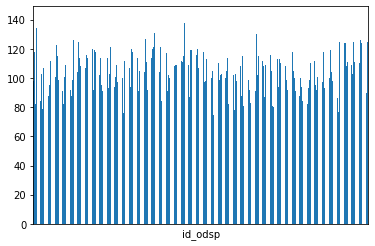

In [180]:
# isolate spanish primera liga 2013/2014 for analysis
sp_2014_games = games.loc[(games.country=='spain')&(games.league=='SP1')&(games.season==2014),'id_odsp']
events_sp_2014 = events.loc[events.id_odsp.isin(sp_2014_games),:]
events_sp_2014.groupby(['id_odsp']).id_event.count().plot.bar(xticks=[]);

We see between 80 and 120 events per game

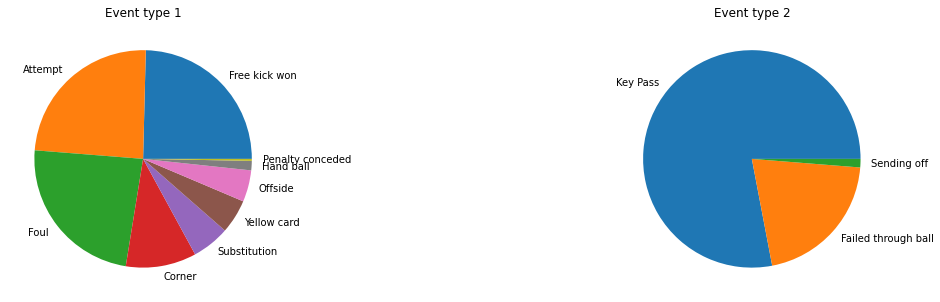

In [181]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
event_counts = events_sp_2014.event_type.value_counts()
event_counts = event_counts[event_counts>50]
ax = axs[0]
ax.pie(event_counts,labels=[event_type[v] for v in event_counts.index.values]);
ax.set_title('Event type 1');
event_counts2 = events_sp_2014.event_type2.value_counts()
event_counts2 = event_counts2[event_counts2>50]
ax = axs[1]
ax.pie(event_counts2,labels=[event_type2[v-11] for v in event_counts2.index.values]);
ax.set_title('Event type 2');


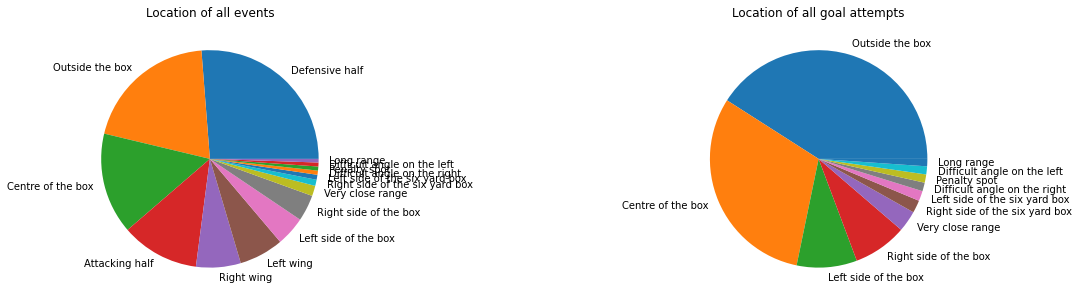

In [182]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
ax = axs[0]
events_loc = events_sp_2014.location.value_counts()
events_loc = events_loc[events_loc>100]
ax.pie(events_loc,labels=[location[v] for v in events_loc.index.values]);
ax.set_title('Location of all events');

ax = axs[1]
shot_loc = events_sp_2014.loc[events_sp_2014.event_type==1].location.value_counts()
shot_loc = shot_loc[shot_loc>100]
ax.pie(shot_loc,labels=[location[v] for v in shot_loc.index.values]);
ax.set_title('Location of all goal attempts');



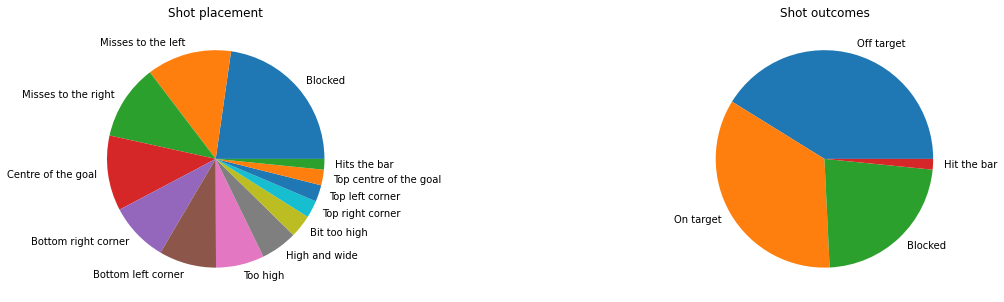

In [183]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
ax = axs[0]
shot_place_c = events_sp_2014.shot_place.value_counts()
shot_place_c = shot_place_c[shot_place_c>100]
ax.pie(shot_place_c,labels=[shot_place[v] for v in shot_place_c.index.values]);
ax.set_title('Shot placement');

ax = axs[1]
shot_outcome_c = events_sp_2014.loc[events_sp_2014.event_type==1].shot_outcome.value_counts()
shot_outcome_c = shot_outcome_c[shot_outcome_c>100]
ax.pie(shot_outcome_c,labels=[shot_outcome[v] for v in shot_outcome_c.index.values]);
ax.set_title('Shot outcomes');




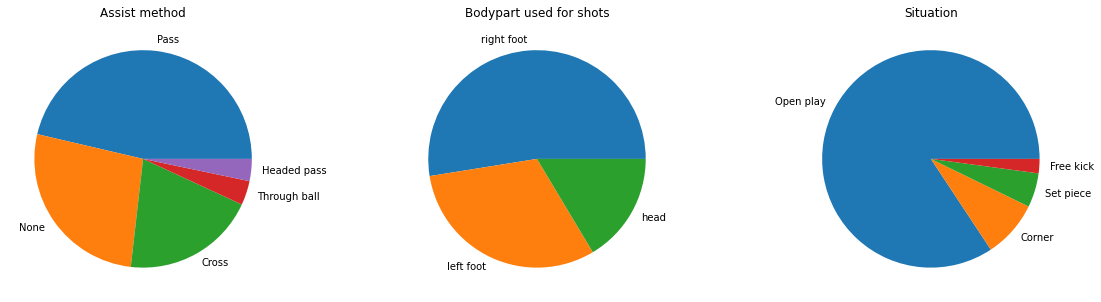

In [184]:
fig,axs = plt.subplots(1,3,figsize=(20,5))
ax = axs[0]
assist_method_c = events_sp_2014.loc[events_sp_2014.event_type==1].assist_method.value_counts()
assist_method_c = assist_method_c[assist_method_c>100]
ax.pie(assist_method_c,labels=[assist_method[v] for v in assist_method_c.index.values]);
ax.set_title('Assist method');

ax = axs[1]
bodypart_c = events_sp_2014.loc[events_sp_2014.event_type==1].bodypart.value_counts()
bodypart_c = bodypart_c[bodypart_c>100]
ax.pie(bodypart_c,labels=[bodypart[v] for v in bodypart_c.index.values]);
ax.set_title('Bodypart used for shots')

ax = axs[2]
situation_c = events_sp_2014.loc[events_sp_2014.event_type==1].situation.value_counts()
situation_c = situation_c[situation_c>100]
ax.pie(situation_c,labels=[situation[v] for v in situation_c.index.values]);
ax.set_title('Situation')
plt.show()


# Preferred foot database 
I use another player dataset here that records player footedness. The data isn't totally reliable - two (or more) players can sometimes have the same name and the database sometimes records player as preferring different feet at different times.

18.65% of events are missing a preferred foot
16.78% of attempts are missing a preferred foot


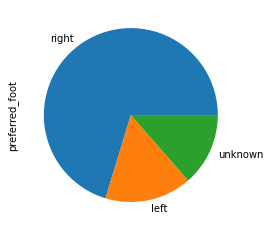

In [185]:
pref_foot = pd.DataFrame(columns=['player_api_id','preferred_foot'])
for p in player_attributes.player_api_id.unique():
  pref_foot_list = np.array(player_attributes.loc[player_attributes.player_api_id == p,'preferred_foot'])
  if any(pref_foot_list=='left') & any(pref_foot_list=='right'):
    foot = 'unknown'
  elif any(pref_foot_list=='left'):
    foot = 'left'
  elif any(pref_foot_list=='right'):
    foot = 'right'
  else:
    foot = 'unknown'
  pref_foot = pref_foot.append({'player_api_id':p,'preferred_foot':foot},ignore_index=True)

player_foot_df = pd.merge(player.loc[:,['player_name','player_api_id']],pref_foot,on='player_api_id',how='left')
player_foot_df = player_foot_df[['player_name','preferred_foot']]

v = player_foot_df.player_name.value_counts();non_unique_names = v[v>1].index.values
# if all the players with a given (non-unique) name have the same footedness then we can record that foot
for n in non_unique_names:
  if np.all(player_foot_df.loc[player_foot_df.player_name==n,:].preferred_foot=='right'):
    foot = 'right'
  elif np.all(player_foot_df.loc[player_foot_df.player_name==n,:].preferred_foot=='left'):
    foot = 'left'
  else:
    foot = 'unknown'
  player_foot_df =  player_foot_df.loc[player_foot_df.player_name!=n,:]
  player_foot_df.append({'player_name':n,'preferred_foot':foot},ignore_index=True)

player_foot_df.rename(columns={'player_name':'player'},inplace=True)
player_foot_df.player = player_foot_df.player.str.lower()
events = pd.merge(events,player_foot_df,left_on='player',right_on='player',how='left')

missing_events = (np.sum((events.preferred_foot.isna()) & (~events.player.isna())))/np.sum(~events.player.isna())
print('{}% of events are missing a preferred foot'.format(round(missing_events*100,2)))

missing_attempts = np.sum((events.preferred_foot.isna()) & (~events.player.isna()) & (events.event_type==1))/np.sum((~events.player.isna())&(events.event_type==1))
print('{}% of attempts are missing a preferred foot'.format(round(missing_attempts*100,2)))

events.preferred_foot.fillna('unknown')
events[events.event_type==1].preferred_foot.value_counts().plot.pie();

Lets see how players stats compare on their good and bad foot. I only use players for which the preferred foot is known.

percentage of "good foot" shots that result in goals = 10.87%
percentage of "bad foot" shots that result in goals = 10.34%


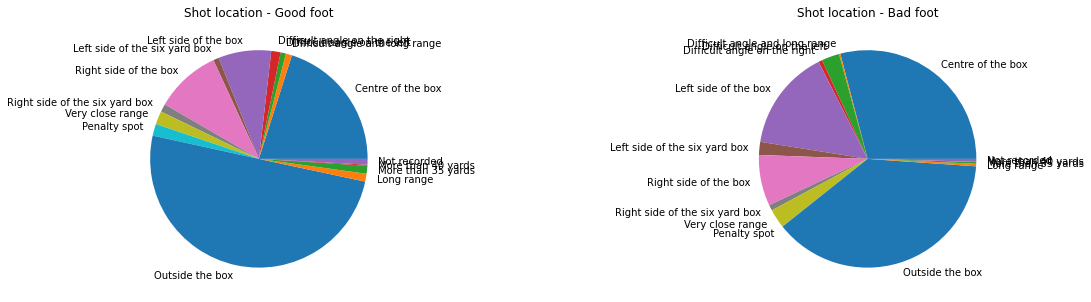

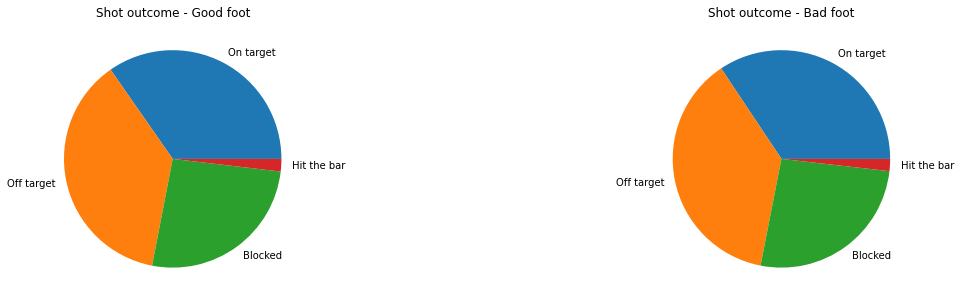

In [186]:
idx_good_foot = (events.event_type==1) & ((events.bodypart==2)&(events.preferred_foot=='left') | (events.bodypart==1)&(events.preferred_foot=='right'))
idx_bad_foot = (events.event_type==1) & ((events.bodypart==1)&(events.preferred_foot=='left') | (events.bodypart==2)&(events.preferred_foot=='right'))


fig,axs = plt.subplots(1,2,figsize=(20,5))
ax = axs[0]
loc_g_f = events.loc[idx_good_foot,'location'].value_counts()
loc_g_f.sort_index(inplace=True)
#loc_g_f = loc_g_f[loc_g_f>100]
ax.pie(loc_g_f,labels=[location[v] for v in loc_g_f.index.values]);
ax.set_title('Shot location - Good foot');

ax = axs[1]
loc_b_f = events.loc[idx_bad_foot,'location'].value_counts()
loc_b_f.sort_index(inplace=True)
#loc_b_f = loc_b_f[loc_b_f>100]
ax.pie(loc_b_f,labels=[location[v] for v in loc_b_f.index.values]);
ax.set_title('Shot location - Bad foot');


fig,axs = plt.subplots(1,2,figsize=(20,5))
ax = axs[0]
outcome_g_f = events.loc[idx_good_foot,'shot_outcome'].value_counts()
outcome_g_f.sort_index(inplace=True)
#outcome_g_f = outcome_g_f[outcome_g_f>100]
ax.pie(outcome_g_f,labels=[shot_outcome[v] for v in outcome_g_f.index.values]);
ax.set_title('Shot outcome - Good foot');

ax = axs[1]
outcome_b_f = events.loc[idx_bad_foot,'shot_outcome'].value_counts()
outcome_b_f.sort_index(inplace=True)
#outcome_b_f = outcome_b_f[outcome_b_f>100]
ax.pie(outcome_b_f,labels=[shot_outcome[v] for v in outcome_b_f.index.values]);
ax.set_title('Shot outcome - Bad foot');



print('percentage of "good foot" shots that result in goals = {:.2f}%'.format(events[idx_good_foot].is_goal.mean()*100))
print('percentage of "bad foot" shots that result in goals = {:.2f}%'.format(events[idx_bad_foot].is_goal.mean()*100))



At first it may seem counterintuitive that a shot a player takes with his weaker foot has, on average, a similar probability of scoring as a shot taken with his stronger foot. 

From the above chart we can see what is going on here. Players are much less likely to use their weaker foot for more difficult shots. If a player takes on a long range shot, he will likely have more time to set himself up to shoot on his preferred side than if he takes a snapshot in a crowded penalty area. It seems like players, aware of their own strengths and weaknesses, compensate for the relative weakness of their "bad" foot by only shooting when the chances of scoring are high enough so that the xG on either foot balances.

Note that xG features usually do not include player attributes or abilities since the model is used to measure the quality of chances and hence measure players' ability to take advantage of the opportunities that come their way. However I will include preferred foot as a feature. Teams deliberately choose players to play in positions that maximize their chances of getting goal scoring opportunities that fall to their preferred foot. For example wide forwards often play on the opposite side to their preferred foot so that they can cut inside a full back onto their strong foot for a shot a la the left footed Arjen Robben.
Thus the quality of a chance that falls to a player like Robben on the left side of the pitch is much lower than a chance that he gets on the right. So if a manager were to play Robben on the left side of the attack, he would almost certainly underperform his xG (from a model that ignore footedness) compared to if he played in his natural position. A model that takes footedness into account would could a fairer assessment of the quality of his chance-taking. 

# Features for the xG model

I will build 3 versions of the model, differentiated according to the features I consider
1.   *basic* features such a location, situation, assist type and whether the shot was a header.
2.   above features plus the foot a shot was taken with and the players preferred foot.
3.   the features from the first 2 models plus some *behavioural* features such as whether a team is winning or losing, playing at home or away and the time in the match when the chance falls. 

The behavioural features are derived below:

*   whether the team is home or away. Does the presence of partisan supporters impact on the shooter, positively or negatively.
*   whether the team is winning or losing. A team that is behind in a match might throw caution to the wind and defend less dilligently. With fewer players behind the ball, chances should be easier to convert.
*   time in the match. Do tired teams give up better quality chances.
*   which team scored  the last goal. There seems to be a momentum effect, is this observable in xG. 
*   whether one team has a numerical advantage due to red cards.


In [187]:
event_id_list = []
current_hg_list = [] # current home score in the match
current_ag_list = [] # current away score in the match
last_goal_list = [] # who scored last
event_team_list = []
red_h_list = [] # number of red cards, home team
red_a_list = [] # number of red cards, away team
# now we step through all events and update these lists
for g in tqdm(games.id_odsp):
  current_hg = 0;current_ag = 0;current_rh = 0;current_ra = 0;
  last_goal = 0 # 1 for home, 2 for away, 0 for no goals yet
  for r in events.loc[events.id_odsp==g,:].iterrows():
    event_id_list.append(r[1].id_event)
    event_team_list.append(r[1].side)
    current_hg_list.append(current_hg)
    current_ag_list.append(current_ag)
    last_goal_list.append(last_goal)
    red_h_list.append(current_rh)
    red_a_list.append(current_ra)
    # update the variables current_hg, current_ag and last_goal
    if r[1].is_goal == 1:
      # identify which team scored
      if r[1].side == 1: # home goal
        current_hg = current_hg+1
        last_goal = 1
      else: # away goal
        current_ag = current_ag+1
        last_goal = 2
    if r[1].event_type == 6: # red card
      # identify which side had a player sent off
      if r[1].side == 1: # home goal
        current_rh = current_rh+1
      else: # away goal
        current_ra = current_ra+1

extra_features = pd.DataFrame(columns=['id_event','side','hg','ag','last_goal','gd','score_cat','last_f_a','red_h','red_a'])
extra_features.id_event = event_id_list
extra_features.hg = current_hg_list
extra_features.ag = current_ag_list
extra_features.last_goal = last_goal_list
extra_features.side = event_team_list
extra_features.red_h = red_h_list
extra_features.red_a = red_a_list

extra_features.loc[extra_features.side==1,'gd'] = extra_features.hg - extra_features.ag 
extra_features.loc[extra_features.side==2,'gd'] = extra_features.ag - extra_features.hg 

# score_cat - 5 classes 
# 1. winning by 2 or more goals
# 2. winning by 1 goal
# 3. drawing
# 4. losing by 1 goal
# 5. losing by 2 or more goals
extra_features.loc[extra_features.gd>=2,'score_cat'] = 1
extra_features.loc[extra_features.gd==1,'score_cat'] = 2
extra_features.loc[extra_features.gd==0,'score_cat'] = 3
extra_features.loc[extra_features.gd==-1,'score_cat'] = 4
extra_features.loc[extra_features.gd<=-2,'score_cat'] = 5
# last_f_a 3 classes
# 1. scored by the event side      
# 2. conceded by the event side 
# 3. no goal so far     
extra_features.loc[extra_features.side == extra_features.last_goal,'last_f_a'] = 1
extra_features.loc[extra_features.side != extra_features.last_goal,'last_f_a'] = 2
extra_features.loc[extra_features.last_goal==0,'last_f_a'] = 3
# numerical advantage 3 classes
# 1. event side hsa numerical advantage
# 2. non-event side has numerical advantage
# 3. numerical equality

# if the`away team has more red cards then the home team has num adv. and vice versa
extra_features.loc[extra_features.red_a == extra_features.red_h,'num_adv'] = 3
extra_features.loc[(extra_features.side==1)&(extra_features.red_a > extra_features.red_h),'num_adv'] = 1 
extra_features.loc[(extra_features.side==1)&(extra_features.red_a < extra_features.red_h),'num_adv'] = 2 
extra_features.loc[(extra_features.side==2)&(extra_features.red_a > extra_features.red_h),'num_adv'] = 2 
extra_features.loc[(extra_features.side==2)&(extra_features.red_a < extra_features.red_h),'num_adv'] = 1 

extra_features = extra_features.loc[:,['id_event','score_cat','last_f_a','num_adv']]
events = pd.merge(events,extra_features,on='id_event',how='left')

# create another feature based on WHEN in a match an event occurs
events.loc[events.time <=22,'time_cat'] = 1
events.loc[events.time.between(23,45),'time_cat'] = 2
events.loc[events.time.between(46,67),'time_cat'] = 3
events.loc[events.time >=68,'time_cat'] = 4

Now I create the full DataFrame of features. We filter the events for attempts on goal.

In [188]:
attempts = events.loc[events.event_type==1,:];del events
attempts.set_index('id_event',inplace=True)


features = attempts.loc[:,['is_goal','fast_break','location', 'assist_method', 'situation','bodypart','preferred_foot','side','score_cat','last_f_a','time_cat','num_adv']] 
# one hot version of the features
features_oh = pd.get_dummies(features, columns=['location', 'assist_method', 'situation','bodypart','preferred_foot','side','score_cat','last_f_a','time_cat','num_adv'])
features_oh.drop('side_2',axis=1,inplace=True);features_oh.rename(columns={'side_1':'side'},inplace=True)

time_cat = {1:'first quarter',2:'second quarter',3:'third quarter',4:'fourth quarter'}
num_adv = {1:'numerical advantage',2:'numerical disadvantage',3:'numerical equality'}
score_cat = {1:'winning by >1',2:'winning by 1',3:'drawing',4:'losing by 1',5:'losing by >1'}
last_goal = {1:'last goal for',2:'last goal against',3:'no goals'}
pref_foot_cat = {1:'preferred_foot_left',2:'preferred_foot_right',3:'preferred_foot_unknown'}
new_col_names = []
orig_column_names = features_oh.columns
for i in features_oh.columns:
  a = i.split('_')
  if i.find('loc') > -1:
    new_col_names.append(location[int(float(a[-1]))])
  elif i.find('body') > -1:
    new_col_names.append(bodypart[int(float(a[-1]))])
  elif i.find('situation') > -1:
    new_col_names.append(situation[int(float(a[-1]))])
  elif i.find('assist') > -1:
    new_col_names.append(assist_method[int(float(a[-1]))])
  elif i.find('score') > -1:
    new_col_names.append(score_cat[int(float(a[-1]))])
  elif i.find('last') > -1:
    new_col_names.append(last_goal[int(float(a[-1]))])
  elif i.find('time') > -1:
    new_col_names.append(time_cat[int(float(a[-1]))])
  elif i.find('num') > -1:
    new_col_names.append(num_adv[int(float(a[-1]))])
  else:
    new_col_names.append(i)
features_oh.columns = new_col_names

hold_out_games = games.loc[(games.country.isin(['england','france']))&(games.league.isin(['E0','F1']))&(games.season==2015),'id_odsp']
features_oh_hold_out = features_oh.loc[features.index.isin(events_hold_out.id_event),:]
features_oh_train_test = features_oh.loc[~features.index.isin(events_hold_out.id_event),:]

all_categories = ['is_goal', 
            'fast_break',  
            'Centre of the box','Difficult angle and long range', 'Difficult angle on the left','Difficult angle on the right', 'Left side of the box',
            'Left side of the six yard box', 'Right side of the box','Right side of the six yard box', 'Very close range', 'Penalty spot',
            'Outside the box', 'Long range', 'More than 35 yards','More than 40 yards', 
            'Not recorded', 'None', 'Pass', 'Cross', 'Headed pass', 'Through ball', 
            'Open play', 'Set piece', 'Corner','Free kick',
            'head', 
            'right foot', 'left foot',  'preferred_foot_left','preferred_foot_right', 'preferred_foot_unknown',
            'side',
            'winning by >1','winning by 1', 'drawing', 'losing by 1', 'losing by >1',
            'last goal for', 'last goal against', 'no goals', 
            'first quarter','second quarter', 'third quarter', 'fourth quarter',
            'numerical advantage', 'numerical disadvantage', 'numerical equality']

basic_categories = all_categories[1:27]
foot_categories = ['right foot','left foot','preferred_foot_left','preferred_foot_right','preferred_foot_unknown']
extra_categories = all_categories[32:]
all_categories = basic_categories+foot_categories+extra_categories


Remember the holdout cases are all attempts for Ligue Un 2014/15 and Premier League 2014/15.

In [189]:
X = features_oh_train_test.iloc[:,1:]
y = features_oh_train_test.iloc[:,0].values
X_hold_out = features_oh_hold_out.iloc[:,1:]
y_hold_out = features_oh_hold_out.iloc[:,0].values

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from xgboost import XGBRegressor 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=123456)



# Model 1.1: XGBoost with basic features

It is difficult to evaluate the models. Very few attempts end up being goals - even if we aggregate the xG over an entire match, it is not unusual that it is very different from the actual goals. One should expect though that the more attempts you aggregate the closer the xG should approximate the actual goals.

I will aggregate the attempts in three ways - 
1.   by match
2.   by date
3.   by team

Then I calculate the $R^2$ of goals to xG from each grouping. 


In [190]:
def evaluate_xG(attempts,xG):
  attempts['xG'] = xG
  fig,axs = plt.subplots(1,3,figsize=(30,8))
  match_GvxG = attempts.groupby(['id_odsp']).agg({'is_goal':'sum','xG':'sum'})
  axs[0].scatter(match_GvxG.is_goal,match_GvxG.xG)
  match_r2 = np.corrcoef(match_GvxG.is_goal,match_GvxG.xG)[0,1];match_rmse = np.mean((match_GvxG.is_goal-match_GvxG.xG)**2)
  axs[0].set_title('Total goals vs total xG per match: R 2 = {:.3f} rmse = {:.3f}'.format(match_r2,match_rmse))
  date_GvxG = attempts.groupby(['date']).agg({'is_goal':'sum','xG':'sum'})
  axs[1].scatter(date_GvxG.is_goal,date_GvxG.xG)
  date_r2 = np.corrcoef(date_GvxG.is_goal,date_GvxG.xG)[0,1];date_rmse = np.mean((date_GvxG.is_goal-date_GvxG.xG)**2)
  axs[1].set_title('Total goals vs total xG per date: R 2 = {:.3f} rmse = {:.3f}'.format(date_r2,date_rmse))
  team_GvxG = attempts.groupby(['event_team']).agg({'is_goal':'sum','xG':'sum'})
  axs[2].scatter(team_GvxG.is_goal,team_GvxG.xG)
  team_r2 = np.corrcoef(team_GvxG.is_goal,team_GvxG.xG)[0,1];team_rmse = np.mean((team_GvxG.is_goal-team_GvxG.xG)**2)
  axs[2].set_title('Total goals vs total xG per team: R 2 = {:.3f} rmse = {:.3f}'.format(team_r2,team_rmse))
  plt.show()


In [191]:
from xgboost import XGBRegressor 
regressor_basic_features = XGBRegressor(objective='binary:logistic', max_depth=20, n_estimators=100)
regressor_basic_features.fit(X_train[basic_categories], y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

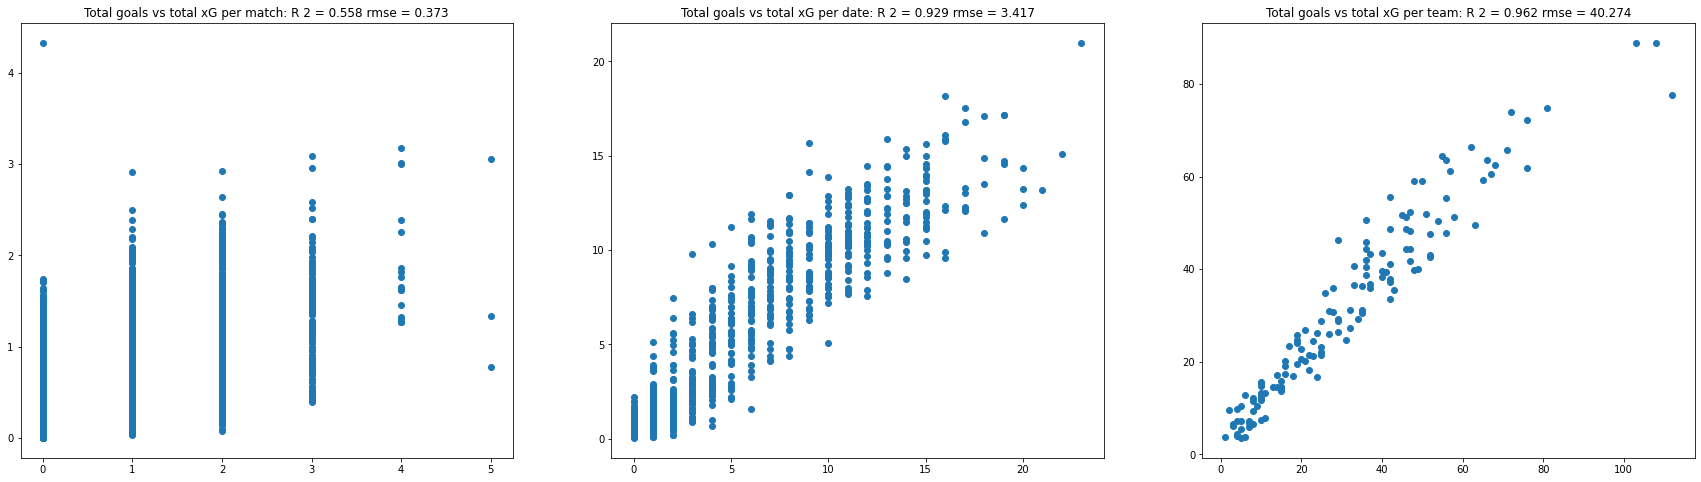

In [192]:

# evaluting the model
xG_basic = regressor_basic_features.predict(X_test[basic_categories])
attempts_test = attempts.loc[X_test.index,:]
attempts_test['xG_basic'] = xG_basic

evaluate_xG(attempts_test,xG_basic)

The more events we aggregate the closer we get to a straight line. The $R^2$ for teams aggregation is 96.2%.

# Model 1.2: XGBoost with basic features plus "foot" features

In [193]:
# the last 18 columns of the feature matrix are the extra features - i won't use them initially
# first i train a random forest using the *basic* features
from xgboost import XGBRegressor 
regressor_basic_plus_foot = XGBRegressor(objective='binary:logistic', max_depth=20, n_estimators=100)
regressor_basic_plus_foot.fit(X_train[basic_categories+foot_categories], y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

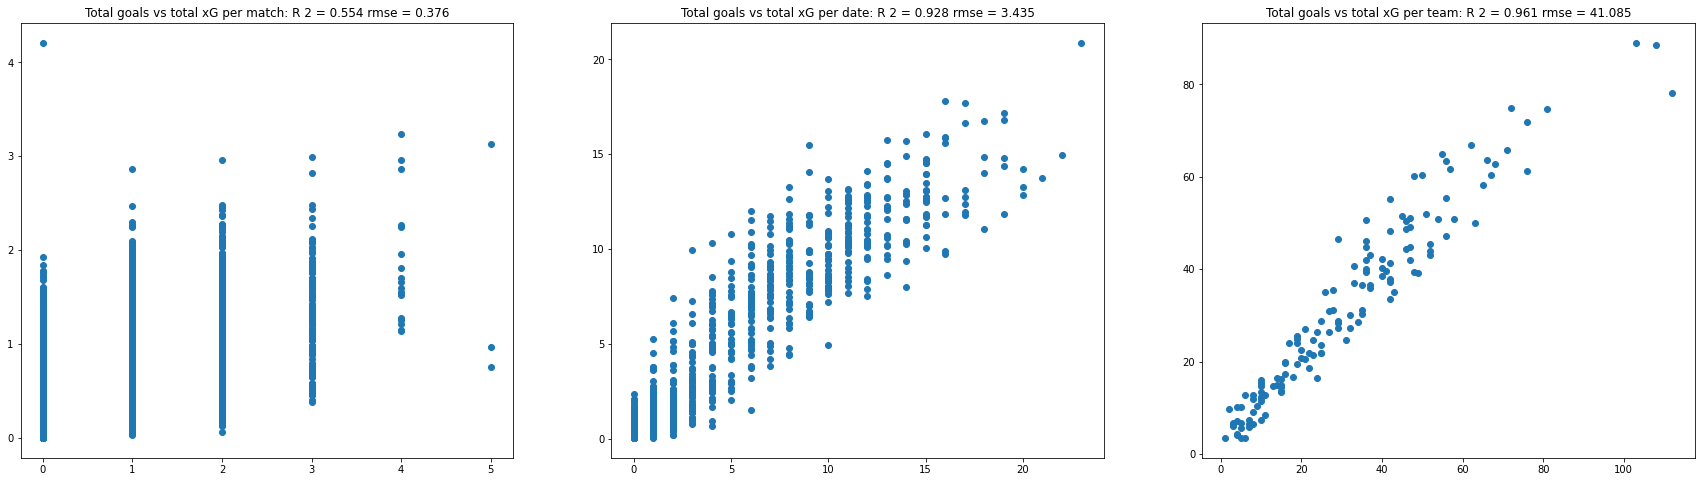

In [194]:
#evaluating the model
xG = regressor_basic_plus_foot.predict(X_test[basic_categories+foot_categories])
attempts_test = attempts.loc[X_test.index,:]
evaluate_xG(attempts_test,xG)

Now we can quantify the difference between a shot on a players good foot and his bad foot (according to the model).

I will copy the validation cases twice and look at all attempts made with a foot. In the first copy I set the player preferred foot to agree with the foot that was used to take the shot and in the second I do the opposite. The two dataset thus differ only in that one feature and comparing the xG for each set we see the importance the model sets on preferred foot over all validation features. 

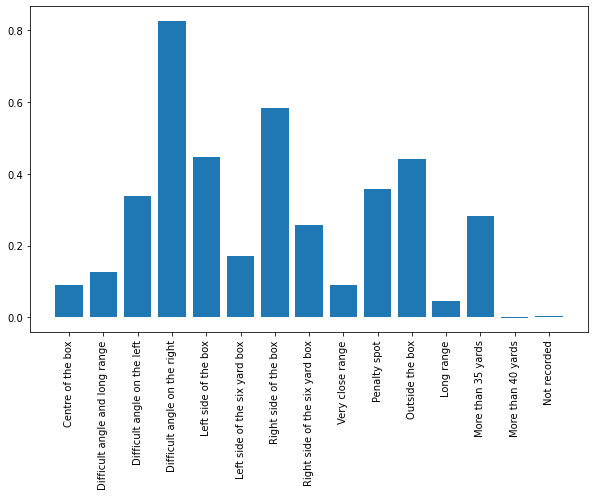

In [195]:
' good foot vs bad '
X_test_all_good_foot = X_test.copy(deep=True)
X_test_all_good_foot.loc[X_test_all_good_foot['left foot']==1,'preferred_foot_left']=1
X_test_all_good_foot.loc[X_test_all_good_foot['left foot']==1,['preferred_foot_right','preferred_foot_unknown']]=0
X_test_all_good_foot.loc[X_test_all_good_foot['right foot']==1,'preferred_foot_right']=1
X_test_all_good_foot.loc[X_test_all_good_foot['right foot']==1,['preferred_foot_left','preferred_foot_unknown']]=0

X_test_all_bad_foot = X_test.copy(deep=True)
X_test_all_bad_foot.loc[X_test_all_bad_foot['right foot']==1,'preferred_foot_left']=1
X_test_all_bad_foot.loc[X_test_all_bad_foot['right foot']==1,['preferred_foot_right','preferred_foot_unknown']]=0
X_test_all_bad_foot.loc[X_test_all_bad_foot['left foot']==1,'preferred_foot_right']=1
X_test_all_bad_foot.loc[X_test_all_bad_foot['left foot']==1,['preferred_foot_left','preferred_foot_unknown']]=0

xG_all_good_foot = regressor_basic_plus_foot.predict(X_test_all_good_foot[basic_categories+foot_categories])
xG_all_bad_foot = regressor_basic_plus_foot.predict(X_test_all_bad_foot[basic_categories+foot_categories])
good_foot_advantage = xG_all_good_foot/xG_all_bad_foot-1

features_test = features.loc[X_test.index,:]
features_test['good_foot_advantage']  = good_foot_advantage
good_foot_advantage_loc = features_test.groupby('location').good_foot_advantage.mean()
fig,ax = plt.subplots(1,1,figsize=(10,6))
plt.bar([location[v] for v in good_foot_advantage_loc.index.values],good_foot_advantage_loc.values);
ax.xaxis.set_tick_params(rotation=90)


This chart shows the xG advantage of taking a shot of the stronger foot vs the weaker foot for different shot locations. For example for a shot from outside the box, the xG is, on average more that 40% large on a players strong foot than on his weaker foot. 

In general, the more difficult the chance the larger is the advantae to using the stronger foot. For easier chance (eg very close range) the advantage is < 10%. The long range category is an anomaly. 

This helps explain the fact that shots on either foot are (more or less) equally likely to result in goals. High xG chances from close range are almost equally effective with either foot while low percentage shots are taken far more infrequently on the weak foot.

# Model 1.3: XGBoost with all features

In [196]:
# the last 18 columns of the feature matrix are the extra features - i won't use them initially
# first i train a random forest using the *basic* features
from xgboost import XGBRegressor 
regressor_all_features = XGBRegressor(objective='binary:logistic', max_depth=20, n_estimators=100)
regressor_all_features.fit(X_train[all_categories], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

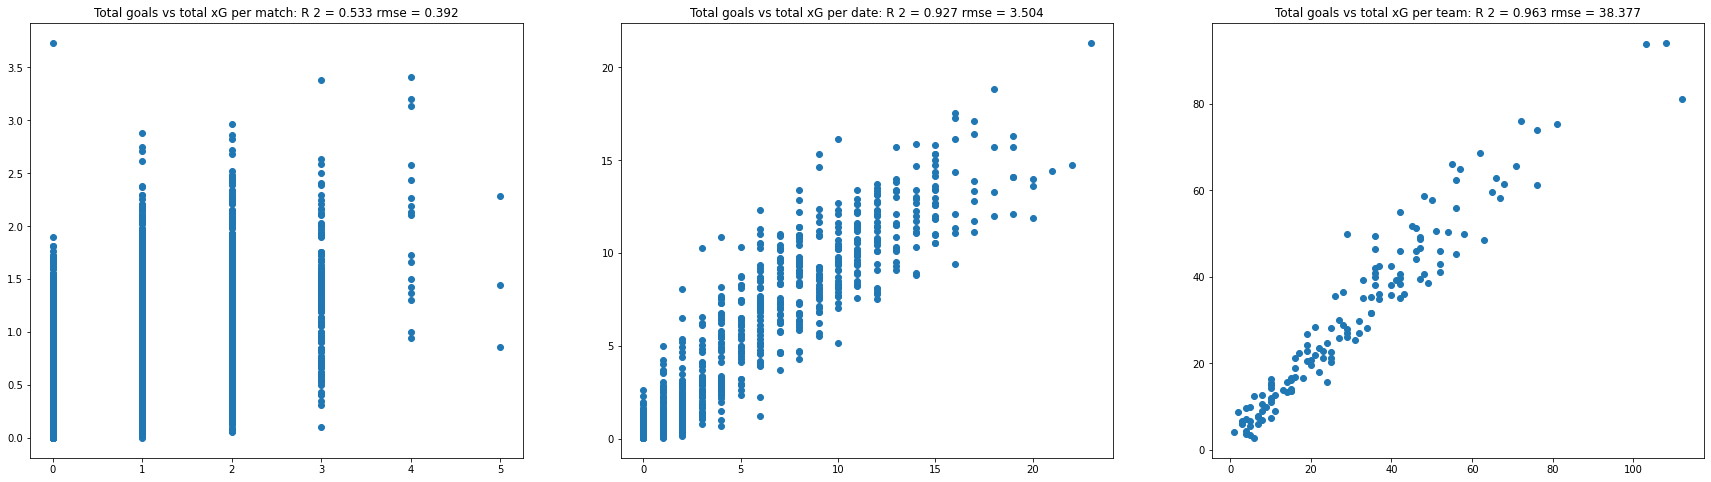

In [197]:
#evaluating the model
xG = regressor_all_features.predict(X_test[all_categories])
attempts_test = attempts.loc[X_test.index,:]
evaluate_xG(attempts_test,xG)

There is only a marginal improvement in $R^2$ from using the extra features. I plot feature importances belwo.

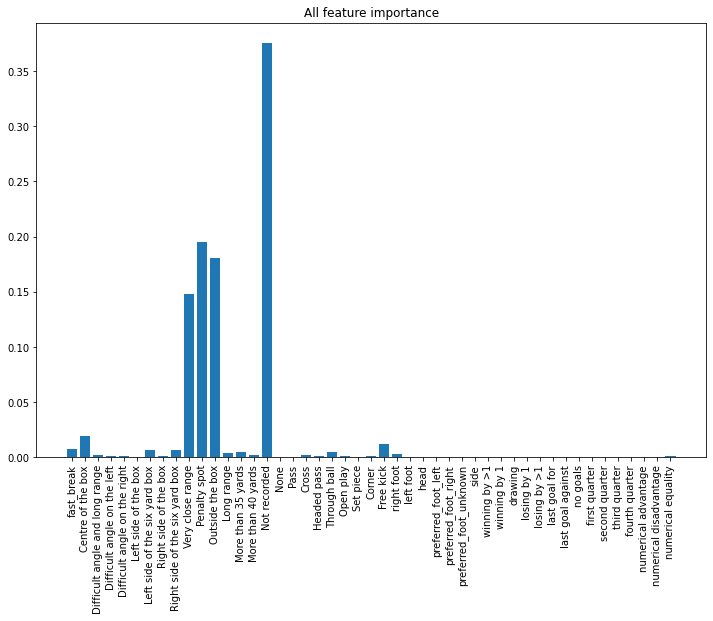

In [198]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# feature importance
#print(regressor_extra_features.feature_importances_)
# plot
plt.figure(figsize=(12,8))
plt.bar(X_test.columns, regressor_all_features.feature_importances_)
plt.title('All feature importance')
plt.xticks(rotation=90)
plt.show()



The location of the shot is the dominant features, dwarfing all others. Lets eliminate those features and plot just the others to get an idea of their relative importance

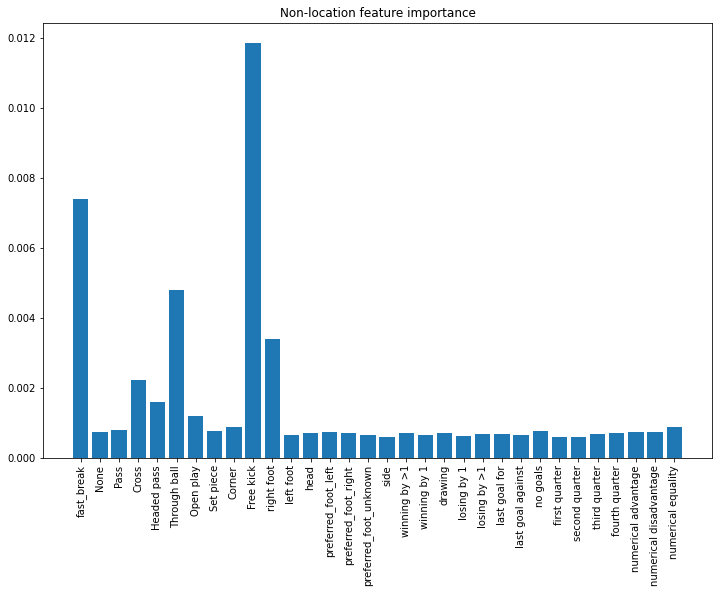

In [199]:
idx_non_loc = [i.find('location') == -1 for i in orig_column_names[1:]]
plt.figure(figsize=(12,8))
plt.bar(X_test.columns[idx_non_loc], regressor_all_features.feature_importances_[idx_non_loc])
plt.xticks(rotation=90)
plt.title('Non-location feature importance')
plt.show()


Fast break and whether it is a free kick are dominant now. None of the new features seem particularly important.


# Neural network models

Now I will check if a neural network fit the data better.

#Model 2.1: Neural net with basic features.

I will use [kerastuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) to define the model architectures so we are treating all models equally. I will let the tuner pick the number of neurons in the first three layers, and the learning rate.

In [200]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units_1', min_value = 32, max_value = 256, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
#  model.add(keras.layers.Dense(10))

  hp_units = hp.Int('units_2', min_value = 32, max_value = 128, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
#  model.add(keras.layers.Dense(10))

  hp_units = hp.Int('units_3', min_value = 32, max_value = 64, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))

  model.add(keras.layers.Dense(1,activation='sigmoid'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),loss=tf.keras.losses.MeanSquaredError(),metrics='mse')
  
  return model

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)



In [236]:
tuner_basic_features = kt.Hyperband(model_builder,
                     objective = 'val_mse', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_basic_features',
                     project_name = 'tuner_basic_features')          

np.random.seed = 12345
tuner_basic_features.search(X_train[basic_categories], y_train, epochs = 10, validation_data = (X_test[basic_categories], y_test), callbacks = [ClearTrainingOutput()])

best_hps_basic = tuner_basic_features.get_best_hyperparameters(num_trials = 1)[0]

nn_model_basic = tuner_basic_features.hypermodel.build(best_hps_basic)
nn_model_basic.fit(X_train[basic_categories], y_train, epochs = 20, validation_data = (X_test[basic_categories], y_test))

INFO:tensorflow:Reloading Oracle from existing project tuner_basic_features/tuner_basic_features/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_basic_features/tuner_basic_features/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
5265/5265 [==============================] - 15s 3ms/step - loss: 0.0823 - mse: 0.0823 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 2/20
5265/5265 [==============================] - 14s 3ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 3/20
5265/5265 [==============================] - 14s 3ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 4/20
5265/5265 [==============================] - 13s 2ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 5/20
5265/5265 [==============================] - 13s 2ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 6/20
5265/5265 [==============================] - 13s 3ms/step - loss: 0.0738 - m

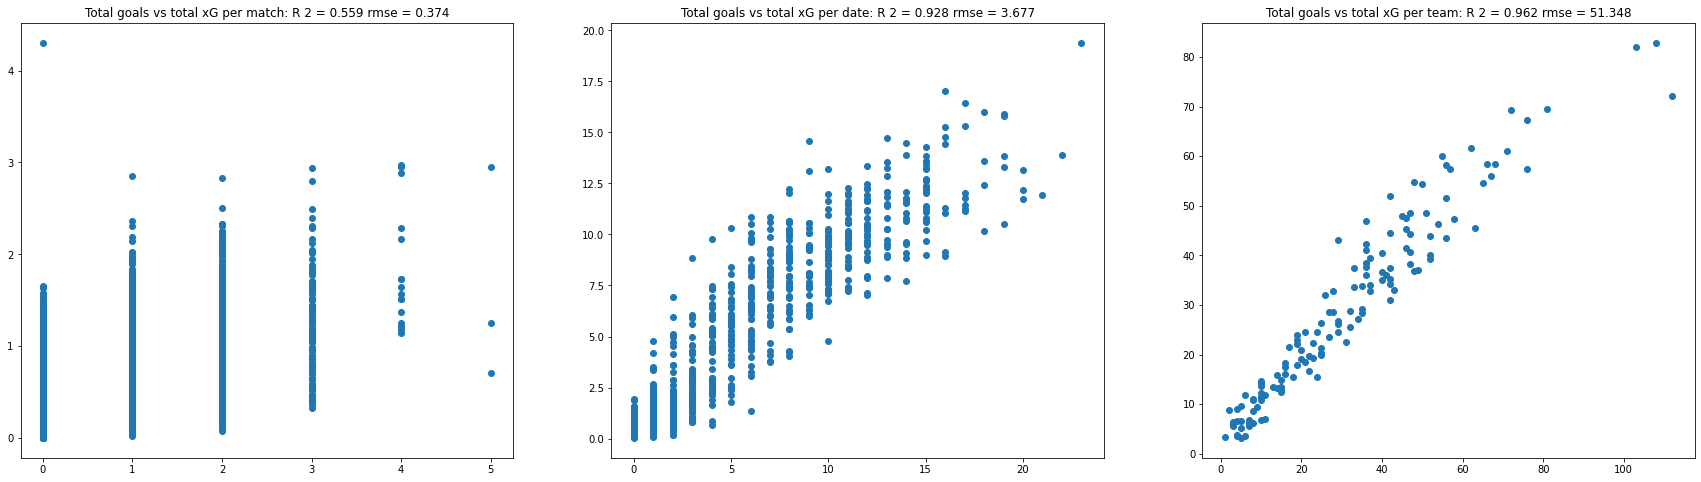

In [237]:
#evaluating the model
xG = nn_model_basic.predict(X_test[basic_categories])
attempts_test = attempts.loc[X_test.index,:]
evaluate_xG(attempts_test,xG)

#Model 2.2: Neural net with basic features plus "foot" features.

In [203]:
tuner_basic_plus_foot = kt.Hyperband(model_builder,
                     objective = 'val_mse', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_basic_plus_foot',
                     project_name = 'tuner_basic_plus_foot')          

np.random.seed = 12345
tuner_basic_plus_foot.search(X_train[basic_categories+foot_categories], y_train, epochs = 10, validation_data = (X_test[basic_categories+foot_categories], y_test), callbacks = [ClearTrainingOutput()])

best_hps_basic_plus_foot = tuner_basic_plus_foot.get_best_hyperparameters(num_trials = 1)[0]


nn_model_basic_plus_foot = tuner_basic_plus_foot.hypermodel.build(best_hps_basic_plus_foot)
nn_model_basic_plus_foot.fit(X_train[basic_categories+foot_categories], y_train, epochs = 20, validation_data = (X_test[basic_categories+foot_categories], y_test))

INFO:tensorflow:Reloading Oracle from existing project tuner_basic_plus_foot/tuner_basic_plus_foot/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_basic_plus_foot/tuner_basic_plus_foot/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0821 - mse: 0.0821 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 2/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0740 - mse: 0.0740 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 3/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 4/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 5/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 6/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0737

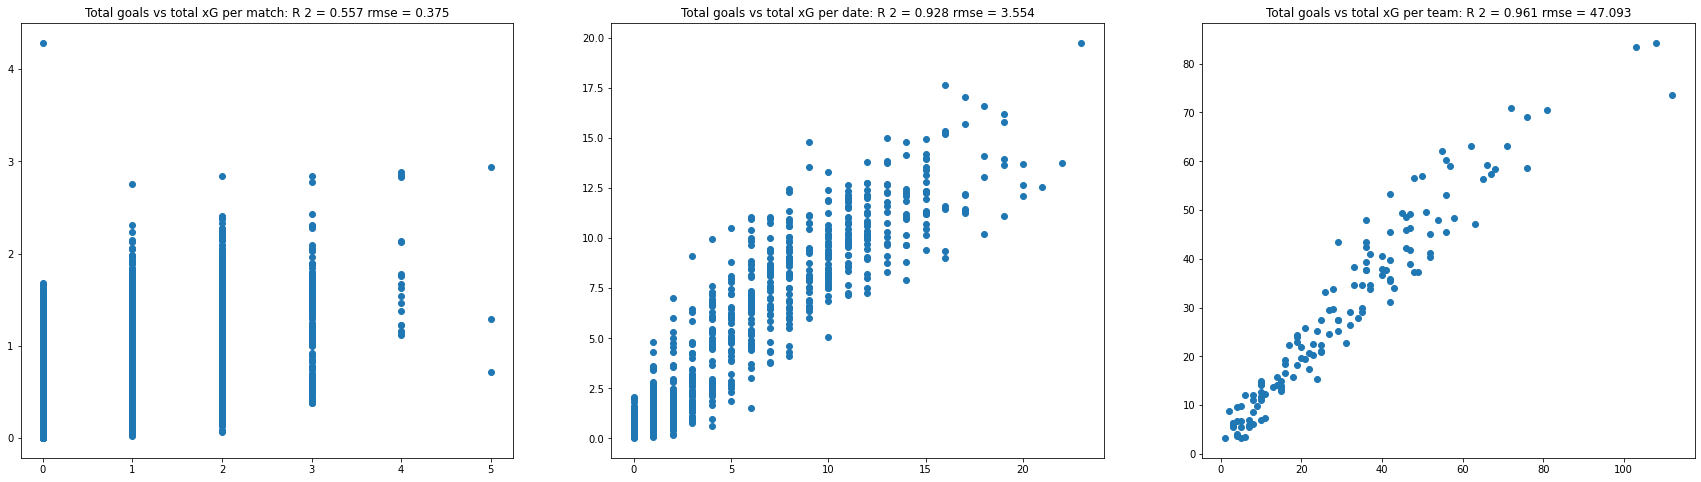

In [204]:
#evaluating the model
xG = nn_model_basic_plus_foot.predict(X_test[basic_categories+foot_categories])
attempts_test = attempts.loc[X_test.index,:]
evaluate_xG(attempts_test,xG)

#Model 2.3: Neural net with all features.

In [205]:
tuner_all_features = kt.Hyperband(model_builder,
                     objective = 'val_mse', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_all_features',
                     project_name = 'tuner_all_features')          

np.random.seed = 12345
tuner_all_features.search(X_train[all_categories], y_train, epochs = 10, validation_data = (X_test[all_categories], y_test), callbacks = [ClearTrainingOutput()])

best_hps_all_features = tuner_all_features.get_best_hyperparameters(num_trials = 1)[0]


nn_model_all_features = tuner_all_features.hypermodel.build(best_hps_all_features)
nn_model_all_features.fit(X_train[all_categories], y_train, epochs = 20, validation_data = (X_test[all_categories], y_test))

INFO:tensorflow:Reloading Oracle from existing project tuner_all_features/tuner_all_features/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_all_features/tuner_all_features/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0827 - mse: 0.0827 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 2/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 3/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0740 - mse: 0.0740 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 4/20
5265/5265 [==============================] - 11s 2ms/step - loss: 0.0738 - mse: 0.0738 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 5/20
5265/5265 [==============================] - 10s 2ms/step - loss: 0.0737 - mse: 0.0737 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 6/20
5265/5265 [==============================] - 11s 2ms/step - loss: 0.0736 - mse: 0.07

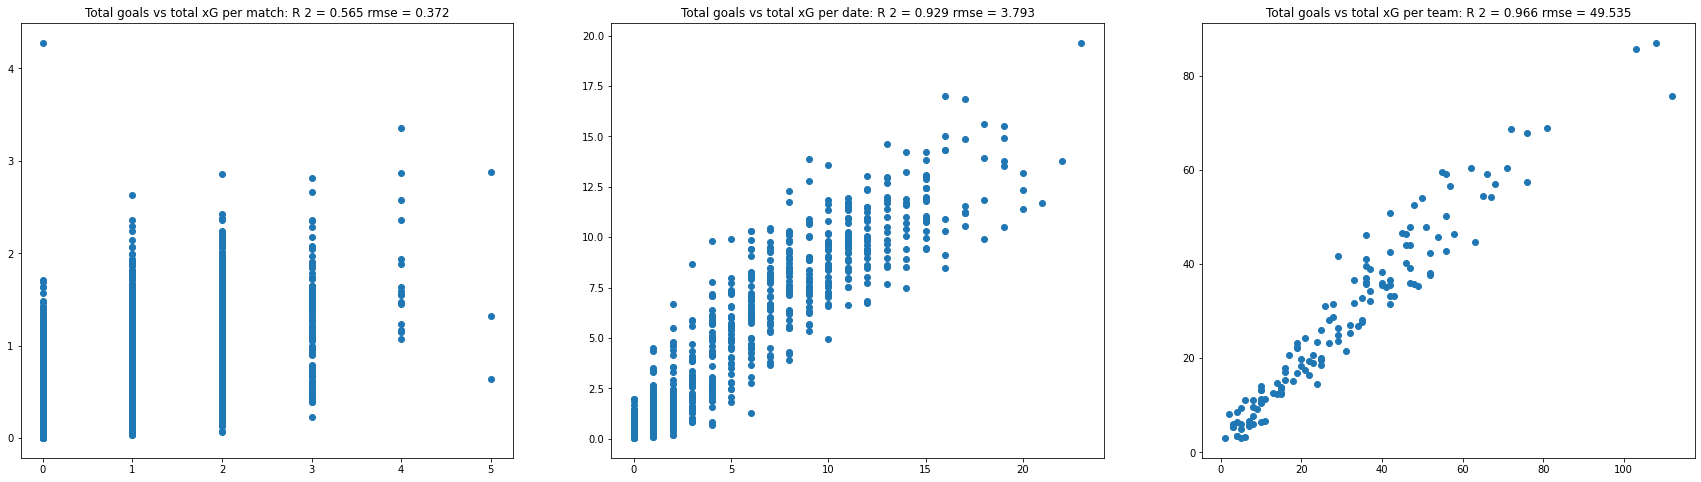

In [206]:
#evaluating the model
xG = nn_model_all_features.predict(X_test[all_categories])
attempts_test = attempts.loc[X_test.index,:]
evaluate_xG(attempts_test,xG)

Based on the $R^2$, adding new features has improved the quality of the model.

# Evaluation of feature importance on NN models

Lets see how much difference the various features make to xG according to the neural network model trained on all features. I will follow same procedure as I used for the preferred foot analysis, making 2 copies of the validation cases and varying one feature and calculating the xG in order to quantify thr importance of the feature to the predictions.

In [221]:
# HOME VS AWAY
X_test_home = X_test.copy(deep=True);X_test_home.side=1
X_test_away = X_test.copy(deep=True);X_test_away.side=0
y_pred_home = nn_model_all_features.predict(X_test_home)
y_pred_away = nn_model_all_features.predict(X_test_away)
bins = np.arange(0,.5,0.01)
plt.subplots(1,1,figsize=(12,8))
plt.hist(y_pred_home, bins, alpha=0.5, label='home: mean = {:f}'.format(np.mean(y_pred_home)))
plt.hist(y_pred_away, bins, alpha=0.5, label='away: mean = {:f}'.format(np.mean(y_pred_away)))
plt.legend(loc='upper right')
plt.show()



<bound method Series.unique of id_event
YkFhV8sD96    1
pzPspZ0l15    1
AuBVBABn55    1
pf3zONKa28    1
6PBUBgtR45    1
             ..
8YVNBNqK3     1
xCOsNVzQ56    1
AXbO4V0E31    1
hWL8blJD91    1
4CNfrs6s64    1
Name: side, Length: 42115, dtype: int64>

There is no significant difference between the home and away team...

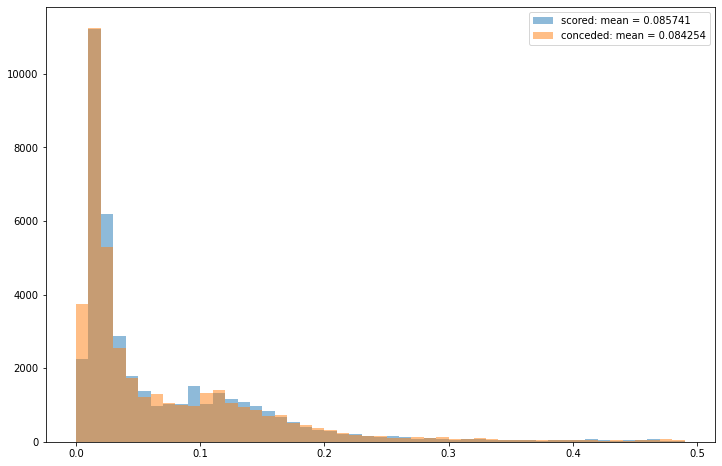

In [208]:
# SCORED LAST VS CONCEDED LAST
X_test_scored = X_test.copy(deep=True);X_test_scored['last goal for']=1;X_test_scored['last goal against']=0;
X_test_conceded = X_test.copy(deep=True);X_test_conceded['last goal for']=0;X_test_conceded['last goal against']=1;
y_pred_scored = nn_model_all_features.predict(X_test_scored)
y_pred_conceded = nn_model_all_features.predict(X_test_conceded)
bins = np.arange(0,.5,0.01)
plt.subplots(1,1,figsize=(12,8))
plt.hist(y_pred_scored, bins, alpha=0.5, label='scored: mean = {:f}'.format(np.mean(y_pred_scored)))
plt.hist(y_pred_conceded, bins, alpha=0.5, label='conceded: mean = {:f}'.format(np.mean(y_pred_conceded)))
plt.legend(loc='upper right')
plt.show()




... or between the team which scored last and conceded last.

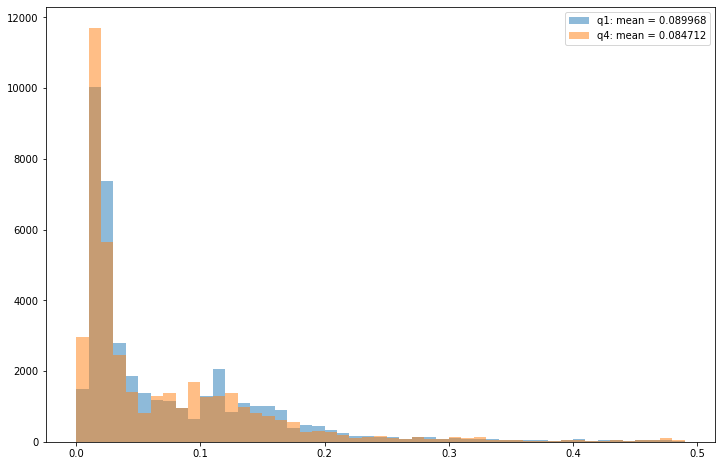

In [209]:
# TIME OF GOAL
time_cols = [i.find('time') > -1 for i in orig_column_names[1:]]
X_test_q1 = X_test.copy(deep=True);X_test_q1.iloc[:,time_cols]=0;X_test_q1.loc[:,'first quarter']=1
X_test_q2 = X_test.copy(deep=True);X_test_q2.iloc[:,time_cols]=0;X_test_q2.loc[:,'second quarter']=1
X_test_q3 = X_test.copy(deep=True);X_test_q3.iloc[:,time_cols]=0;X_test_q3.loc[:,'third quarter']=1
X_test_q4 = X_test.copy(deep=True);X_test_q4.iloc[:,time_cols]=0;X_test_q4.loc[:,'fourth quarter']=1
y_pred_q1 = nn_model_all_features.predict(X_test_q1)
y_pred_q2 = nn_model_all_features.predict(X_test_q2)
y_pred_q3 = nn_model_all_features.predict(X_test_q3)
y_pred_q4 = nn_model_all_features.predict(X_test_q4)
bins = np.arange(0,.5,0.01)
plt.subplots(1,1,figsize=(12,8))
plt.hist(y_pred_q1, bins, alpha=0.5, label='q1: mean = {:f}'.format(np.mean(y_pred_q1)))
plt.hist(y_pred_q4, bins, alpha=0.5, label='q4: mean = {:f}'.format(np.mean(y_pred_q4)))
plt.legend(loc='upper right')
plt.show()



Again the time feature has almost no importance.

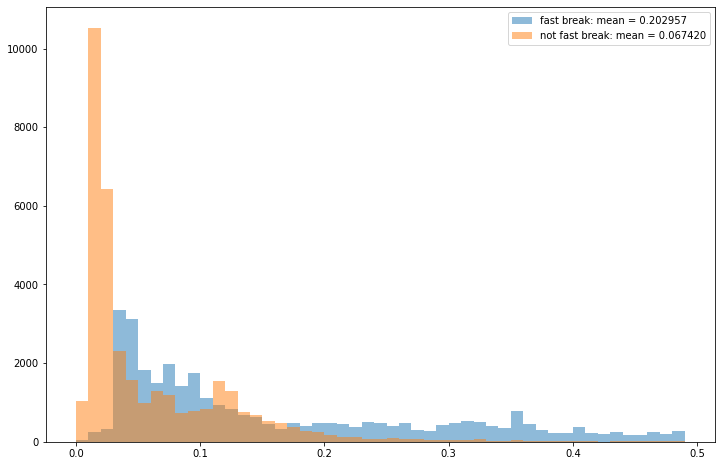

In [210]:
# FAST BREAK
# Here I filter the test set for open play situations only
X_open_play = X_test.loc[X_test['Open play']==1,:]
X_fast_break = X_open_play.copy(deep=True);X_fast_break.loc[:,'fast_break']=1
X_not_fast_break = X_open_play.copy(deep=True);X_not_fast_break.loc[:,'fast_break']=0
y_pred_fast = nn_model_all_features.predict(X_fast_break)
y_pred_not_fast = nn_model_all_features.predict(X_not_fast_break)
bins = np.arange(0,.5,0.01)
plt.subplots(1,1,figsize=(12,8))
plt.hist(y_pred_fast, bins, alpha=0.5, label='fast break: mean = {:f}'.format(np.mean(y_pred_fast)))
plt.hist(y_pred_not_fast, bins, alpha=0.5, label='not fast break: mean = {:f}'.format(np.mean(y_pred_not_fast)))
plt.legend(loc='upper right')
plt.show()


Attempts made in the course of a fast break have a much higher xG compared to equivalent chances. This makes sense - the other team is likely to have players out of position and to have fewer defenders.

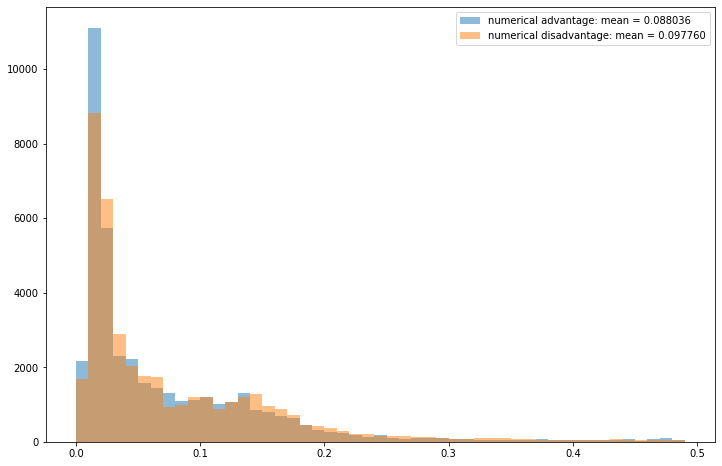

In [211]:
# NUMERICAL ADVANTTAGE
num_cols = [i.find('num') > -1 for i in orig_column_names[1:]]
X_num_adv = X_test.copy(deep=True);X_num_adv.iloc[:,num_cols]=0;X_num_adv.loc[:,'numerical advantage']=1
X_num_dis = X_test.copy(deep=True);X_num_dis.iloc[:,num_cols]=0;X_num_dis.loc[:,'numerical disadvantage']=1
y_pred_adv = nn_model_all_features.predict(X_num_adv)
y_pred_dis = nn_model_all_features.predict(X_num_dis)
bins = np.arange(0,.5,0.01)
plt.subplots(1,1,figsize=(12,8))
plt.hist(y_pred_adv, bins, alpha=0.5, label='numerical advantage: mean = {:f}'.format(np.mean(y_pred_adv)))
plt.hist(y_pred_dis, bins, alpha=0.5, label='numerical disadvantage: mean = {:f}'.format(np.mean(y_pred_dis)))
plt.legend(loc='upper right')
plt.show()



Surprisingly though, numerical advantage makes little difference. You might think that similar logic to the fast break case would imply that if the defending team has fewer players, then there ought to be fewer players between the shooter and the goal, however this seems not to be the case.



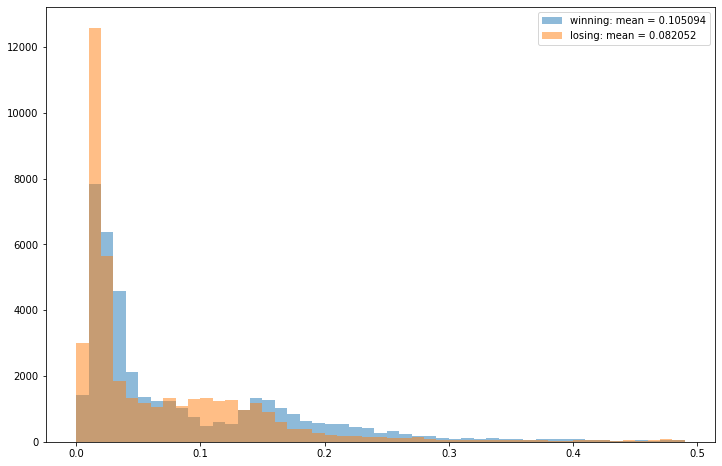

In [212]:
# WINNING VS LOSING
X_test_winning = X_test.copy(deep=True);X_test_winning['winning by >1']=1;
X_test_winning['winning by 1']=0;X_test_winning['drawing']=0;X_test_winning['losing by 1']=0;X_test_winning['losing by >1']=0
X_test_losing = X_test.copy(deep=True);X_test_losing['losing by >1']=1;
X_test_losing['winning by 1']=0;X_test_losing['drawing']=0;X_test_losing['losing by 1']=0;X_test_losing['winning by >1']=0
y_pred_winning = nn_model_all_features.predict(X_test_winning)
y_pred_losing = nn_model_all_features.predict(X_test_losing)
bins = np.arange(0,.5,0.01)
plt.subplots(1,1,figsize=(12,8))
plt.hist(y_pred_winning, bins, alpha=0.5, label='winning: mean = {:f}'.format(np.mean(y_pred_winning)))
plt.hist(y_pred_losing, bins, alpha=0.5, label='losing: mean = {:f}'.format(np.mean(y_pred_losing)))
plt.legend(loc='upper right')
plt.show()



Of the extra features I've introduced, winning vs losing has the most importance - specfically winning by more than one goal as opposed to losing by more than one. Of course this could simply be a consequence of the fact that a team that is 2 goals ahead is likely a *better* team with *better* players  who are more likely to score a given chance - or it could be that the losing team defends less dilligently as they chase a goal. 
If it is the former then arguably  this isn't a fair feature to use.

# xG tables for holdout seasons

Once you have a xG model it is straightforward to model expected points (xPts) by comparing the Poisson distributions of goals for each team. We can aggregate xPts over a whole season and create a table which can give valuable insights whem compared to the actual table. I will now do that for the 2 holdout seasons on the 3 neural network models.

In [213]:
xG_holdout_basic = nn_model_basic.predict(features_oh_hold_out[basic_categories])
xG_holdout_basic_plus_foot = nn_model_basic_plus_foot.predict(features_oh_hold_out[basic_categories+foot_categories])
xG_holdout_all = nn_model_all_features.predict(features_oh_hold_out[all_categories])

attempts_holdout = attempts.loc[features_oh_hold_out.index,:]
attempts_holdout['xg_basic'] = xG_holdout_basic
attempts_holdout['xg_basic_plus_foot'] = xG_holdout_basic_plus_foot
attempts_holdout['xg_all'] = xG_holdout_all

xg_agg_basic = attempts_holdout.groupby(['id_odsp','side']).agg({'xg_basic':'sum'}).unstack();xg_agg_basic.columns=['xG_h','xG_a']
xg_agg_basic_plus_foot = attempts_holdout.groupby(['id_odsp','side']).agg({'xg_basic_plus_foot':'sum'}).unstack();xg_agg_basic_plus_foot.columns=['xG_h','xG_a']
xg_agg_all_features = attempts_holdout.groupby(['id_odsp','side']).agg({'xg_all':'sum'}).unstack();xg_agg_all_features.columns=['xG_h','xG_a']


def xPts(xG_h,xG_a):
  max_goals = 100
  h_dist = [poisson.pmf(i,xG_h) for i in range(max_goals)]
  a_dist = [poisson.pmf(i,xG_a) for i in range(max_goals)]
  result_mat = np.outer(h_dist,a_dist)
  xP_h = np.sum(np.tril(result_mat,-1))*3+np.sum(np.diag(result_mat))
  xP_a = np.sum(np.triu(result_mat,1))*3+np.sum(np.diag(result_mat))
  return (xP_h, xP_a)

xPts_basic = [xPts(xG_h,xG_a) for xG_h, xG_a in zip(xg_agg_basic.xG_h,xg_agg_basic.xG_a)]
xg_agg_basic['xP_h'] = [t[0] for t in xPts_basic];xg_agg_basic['xP_a'] = [t[1] for t in xPts_basic];

xPts_basic_plus_foot = [xPts(xG_h,xG_a) for xG_h, xG_a in zip(xg_agg_basic_plus_foot.xG_h,xg_agg_basic_plus_foot.xG_a)]
xg_agg_basic_plus_foot['xP_h'] = [t[0] for t in xPts_basic_plus_foot];xg_agg_basic_plus_foot['xP_a'] = [t[1] for t in xPts_basic_plus_foot];

xPts_all = [xPts(xG_h,xG_a) for xG_h, xG_a in zip(xg_agg_all_features.xG_h,xg_agg_all_features.xG_a)]
xg_agg_all_features['xP_h'] = [t[0] for t in xPts_all];xg_agg_all_features['xP_a'] = [t[1] for t in xPts_all];

xg_agg_basic = pd.merge(xg_agg_basic,games.loc[:,['id_odsp','ht','at','fthg','ftag','league']],on='id_odsp',how='left')
xg_agg_basic.rename(columns={'ht':'HT','at':'AT'},inplace=True)

xg_agg_basic_plus_foot = pd.merge(xg_agg_basic_plus_foot,games.loc[:,['id_odsp','ht','at','fthg','ftag','league']],on='id_odsp',how='left')
xg_agg_basic_plus_foot.rename(columns={'ht':'HT','at':'AT'},inplace=True)

xg_agg_all_features  = pd.merge(xg_agg_all_features,games.loc[:,['id_odsp','ht','at','fthg','ftag','league']],on='id_odsp',how='left')
xg_agg_all_features.rename(columns={'ht':'HT','at':'AT'},inplace=True)


In [214]:
def matches_to_table(matches_df):
  table_df = pd.DataFrame(columns = ['team','pos','played','GF','xGF','GA','xGA','GD','xGD','W','D','L','Pts','xPts'])
  teams = matches_df.HT.unique()
  for t in teams:
    won = np.sum((matches_df.HT == t) & (matches_df.fthg > matches_df.ftag)) + np.sum((matches_df.AT == t) & (matches_df.ftag > matches_df.fthg))
    drew = np.sum((matches_df.HT == t) & (matches_df.fthg == matches_df.ftag)) + np.sum((matches_df.AT == t) & (matches_df.fthg == matches_df.ftag))
    lost = np.sum((matches_df.HT == t) & (matches_df.fthg < matches_df.ftag)) + np.sum((matches_df.AT == t) & (matches_df.ftag < matches_df.fthg))
    GF = matches_df.loc[matches_df.HT == t,'fthg'].sum() + matches_df.loc[matches_df.AT == t,'ftag'].sum()
    xGF = matches_df.loc[matches_df.HT == t,'xG_h'].sum() + matches_df.loc[matches_df.AT == t,'xG_a'].sum()
    GA = matches_df.loc[matches_df.HT == t,'ftag'].sum() + matches_df.loc[matches_df.AT == t,'fthg'].sum()
    xGA = matches_df.loc[matches_df.HT == t,'xG_a'].sum() + matches_df.loc[matches_df.AT == t,'xG_h'].sum()
    xPts = matches_df.loc[matches_df.HT == t,'xP_h'].sum() + matches_df.loc[matches_df.AT == t,'xP_a'].sum()
    Pts = 3*won + drew
    table_df.loc[len(table_df),:] = [t,np.nan,won+drew+lost,GF,xGF,GA,xGA,GF-GA,xGF-xGA,won,drew,lost,Pts,xPts]
  table_df.sort_values('Pts',ascending=False,inplace=True)
  table_df['pos'] = range(1,len(table_df)+1)
  table_df.set_index('pos',inplace=True)
  return table_df

def plot_table(table,title,ax):
  #fig,ax = plt.subplots(1,1,figsize=(10,8))
  delta_gf = table.GF - table.xGF 
  delta_ga = table.GA - table.xGA
  delta_pts = table.Pts - table.xPts
  ax.bar(np.arange(len(table))-0.2,delta_gf,width=.2)
  ax.bar(np.arange(len(table)),delta_ga,width=.2)
  ax.bar(np.arange(len(table))+0.2,delta_pts,width=.2)
  ax.xaxis.set_ticklabels(table.team,rotation=90)
  ax.xaxis.set_ticks(range(len(table.team)))
  ax.legend(('delta goal for','delta goals against','delta points'),loc='best');
  mad_ga = np.mean(np.abs(delta_ga))
  mad_gf = np.mean(np.abs(delta_gf))
  mad_pts = np.mean(np.abs(delta_pts))
  ax.set_title(title+': MAD GF = {:.2f}, MAD GA = {:.2f}, MAD Pts = {:.2f}'.format(mad_gf,mad_ga,mad_pts))
  #plt.show()


In [215]:
table_pl_basic_features = matches_to_table(xg_agg_basic.loc[xg_agg_basic.league=='E0'])
table_pl_basic_plus_foot = matches_to_table(xg_agg_basic_plus_foot.loc[xg_agg_basic_plus_foot.league=='E0']) 
table_pl_all_features = matches_to_table(xg_agg_all_features.loc[xg_agg_all_features.league=='E0']) 

table_l1_basic_features = matches_to_table(xg_agg_basic.loc[xg_agg_basic.league=='F1']) 
table_l1_basic_plus_foot = matches_to_table(xg_agg_basic_plus_foot.loc[xg_agg_basic_plus_foot.league=='F1']) 
table_l1_all_features = matches_to_table(xg_agg_all_features.loc[xg_agg_all_features.league=='F1']) 

pd.set_option('display.max_columns',20);pd.set_option('display.width', 1000)
print(table_pl_all_features)



                team played  GF      xGF  GA      xGA   GD       xGD   W   D   L Pts     xPts
pos                                                                                          
1            Chelsea     38  73  62.9019  32  32.4773   41   30.4246  26   9   3  87  69.9631
2    Manchester City     38  83  74.9438  38   37.051   45   37.8928  24   7   7  79  72.1703
3            Arsenal     38  71  66.1687  36  35.0342   35   31.1345  22   9   7  75  70.9908
4     Manchester Utd     38  62  55.6285  37  38.2785   25   17.3499  20  10   8  70  62.5461
5          Tottenham     38  58  48.8212  53  51.9783    5  -3.15712  19   7  12  64  49.4434
6          Liverpool     38  52  54.6574  48   37.747    4   16.9104  18   8  12  62   62.192
7        Southampton     38  54  52.0608  33  35.6255   21   16.4354  18   6  14  60   61.998
8            Swansea     38  46  39.7666  49  51.2503   -3  -11.4837  16   8  14  56  44.9657
9         Stoke City     38  48  41.7237  45  45.3401    3  

Here is the expected points table for the premier league season 2014/15 for model 2.3. For comparison with a commercial system, see https://understat.com/league/EPL/2014.
My model holds up pretty well by comparison.

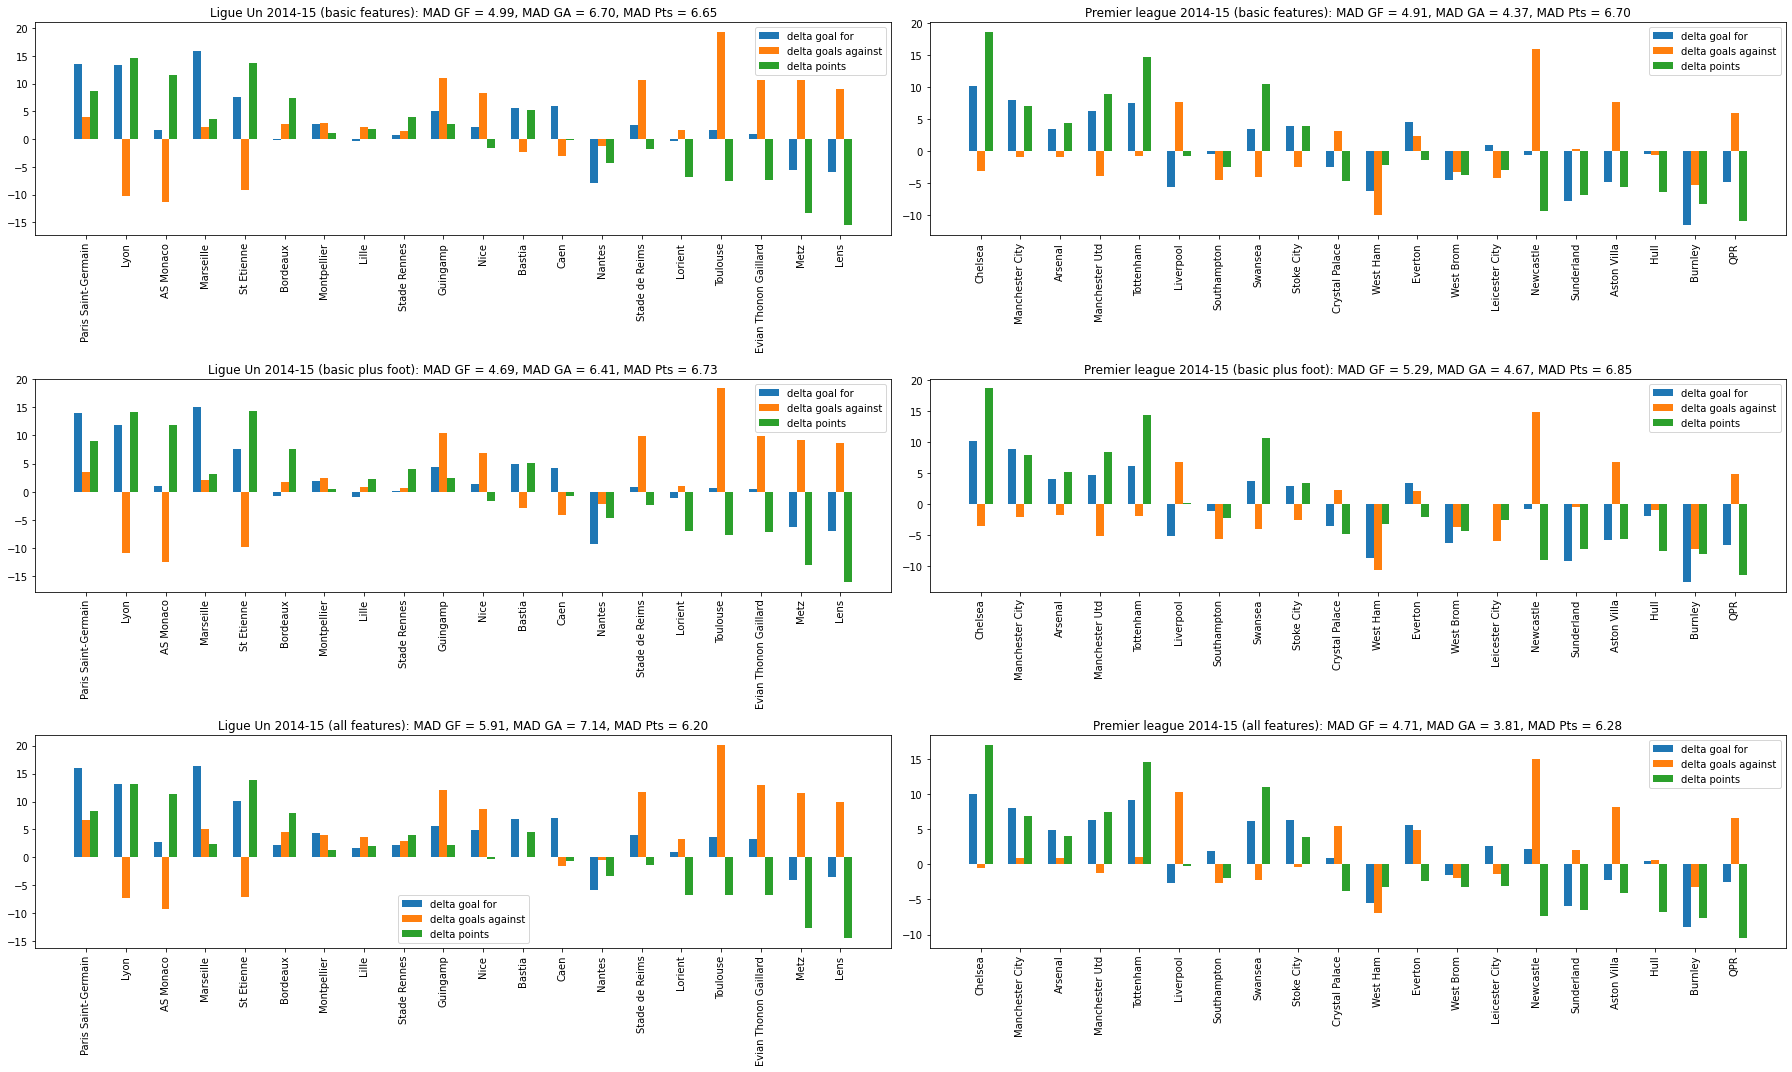

In [216]:
fig,axs = plt.subplots(3,2,figsize=(25,15))
ax =  axs[0][0]
plot_table(table_l1_basic_features,'Ligue Un 2014-15 (basic features)',ax)
ax =  axs[0][1]
plot_table(table_pl_basic_features,'Premier league 2014-15 (basic features)',ax)

ax =  axs[1][0]
plot_table(table_l1_basic_plus_foot,'Ligue Un 2014-15 (basic plus foot)',ax)
ax =  axs[1][1]
plot_table(table_pl_basic_plus_foot,'Premier league 2014-15 (basic plus foot)',ax)


ax =  axs[2][0]
plot_table(table_l1_all_features,'Ligue Un 2014-15 (all features)',ax)
ax =  axs[2][1]
plot_table(table_pl_all_features,'Premier league 2014-15 (all features)',ax)
plt.tight_layout();plt.show()

The model with all features fits the observed data much better as oberved in the lower mean average delta (MAD) points, goals for and goals against. Fitting the observed data well is not necessarily a good thing - every goal chance scored or missed is a random sample from the *true* underlying process and is this is a noisy reading, even over the course of a whole season. 

Note that the teams at the top of the league generally outperform their xG, xGA and xPts and visa versa for the teams at the bottom. There are two ways to interpret this - (1)  the better teams outperform because they have better strikers who are more likely to score from a given chance, and better goalkeepers who carry out more difficult saves, or (2) the xG, xGA and xPts are a true relection of the quality of a team and the ones who finish near the top are likely to be the one who, by chance, outperformed their expected metrics over the season. I suspect that the true reason is a mixture of the 2 points above.

# Conclusion. 
The model I've fitted compares favourably with a commercial model. The extra feature improve the quality of the fit. To improve the model further I think I would need new features - specifically data that tells us how many  defenders are between a shooter and the goal and how close they are, or whether a goal keeper out of position, could be crucial. 